In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import folium
from folium.features import Choropleth
from folium.plugins import HeatMap
import json

In [2]:
df = pd.read_csv('listings.csv')
pd.options.display.max_rows=1000
np.transpose(df[:4])

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3
id,2539,2595,3647,3831
listing_url,https://www.airbnb.com/rooms/2539,https://www.airbnb.com/rooms/2595,https://www.airbnb.com/rooms/3647,https://www.airbnb.com/rooms/3831
scrape_id,20190602163209,20190602163209,20190602163209,20190602163209
last_scraped,2019-06-03,2019-06-03,2019-06-03,2019-06-03
name,Clean & quiet apt home by the park,Skylit Midtown Castle,THE VILLAGE OF HARLEM....NEW YORK !,Cozy Entire Floor of Brownstone
summary,Renovated apt home in elevator building.,"Find your romantic getaway to this beautiful, ...",NaN,Urban retreat: enjoy 500 s.f. floor in 1899 br...
space,"Spacious, renovated, and clean apt home, one b...","- Spacious (500+ft²), immaculate and nicely fu...",WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,Greetings! We own a double-duplex brownst...
description,Renovated apt home in elevator building. Spaci...,"Find your romantic getaway to this beautiful, ...",WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,Urban retreat: enjoy 500 s.f. floor in 1899 br...
experiences_offered,none,none,none,none
neighborhood_overview,Close to Prospect Park and Historic Ditmas Park,Centrally located in the heart of Manhattan ju...,NaN,Just the right mix of urban center and local n...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 39.5+ MB


In [4]:
'''Cleaning data'''
# Remove dollar sign in price
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop host_name
df.drop(['host_name'], axis=1, inplace=True)

# Remove NaNs in zipcode
df = df[df.zipcode.notnull()].reset_index(drop=True)

# Remove NaNs in accomodates
df = df[df.accommodates	.notnull()].reset_index(drop=True)


# Remove NaNs in review_location_score
df = df[df.review_scores_location.notnull()].reset_index(drop=True)


# Remove any zipcode that does not belong to NYC
df = df[(df['zipcode'].str[:1] == '1')]

In [5]:
'''Understanding the data '''
df.neighbourhood_group_cleansed	.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [6]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [7]:
df.neighbourhood_cleansed.unique()

array(['Kensington', 'Midtown', 'Clinton Hill', "Hell's Kitchen",
       'East Harlem', 'Murray Hill', 'Bedford-Stuyvesant',
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'East Village', 'Windsor Terrace', 'Inwood',
       'Harlem', 'Greenpoint', 'Bushwick', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Flatbush', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'NoHo', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Little Italy', 'East Flatbush', 'Tompkinsville', 'Astoria',
       'Eastchester', 

**Exploratory Data Analysis:**

**1.	Hosts and listings**

  Airbnb’s business model connects hosts who rent out their private property to short-term subletters. Assuming that most listings are non-licensed, we expect that the majority of the listing are private or shared room which allows host to continue living in her own home. The graph below is in line with our expectations:

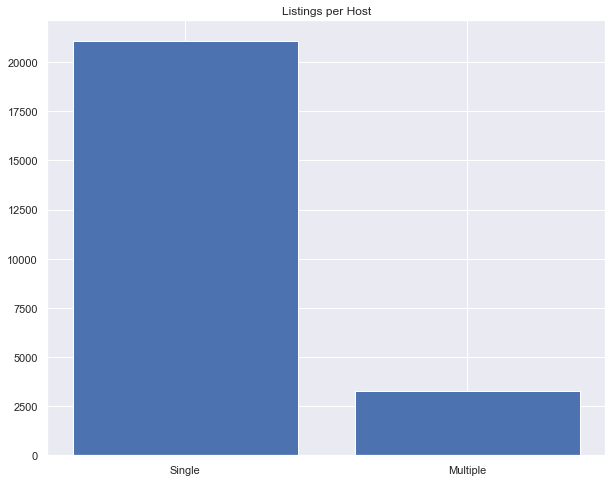

In [8]:
'''Listings per Host'''
# Airbnb hosts can have multiple listings (as we can see above). A host can list separate rooms in the same apartment
# or multiple apartments or homes
listings_per_host=(df.host_id.value_counts() > 1).value_counts()

sns.set(rc={'figure.figsize':(10,8)})
plt.bar(x=['Single', 'Multiple'], height=listings_per_host.values)
plt.title('Listings per Host');

# There are approx 27,500 single listings and 4,000 multiple listings

# Assuming that most listings are non-licensed, we expect that the majority of the listing are private or shared 
# room which allows host to continue living in her own home. The graph below is in line with our expectations. 

There are approximately 27,000 single listings and 4,000 multiple listings. Let us explore the host with multiple listings further: 


In [9]:
top_host=df.host_id.value_counts().head(10)
top_host

219517861    176
61391963      68
16098958      60
30283594      50
7503643       48
1475015       42
2119276       39
120762452     38
22541573      34
51501835      31
Name: host_id, dtype: int64

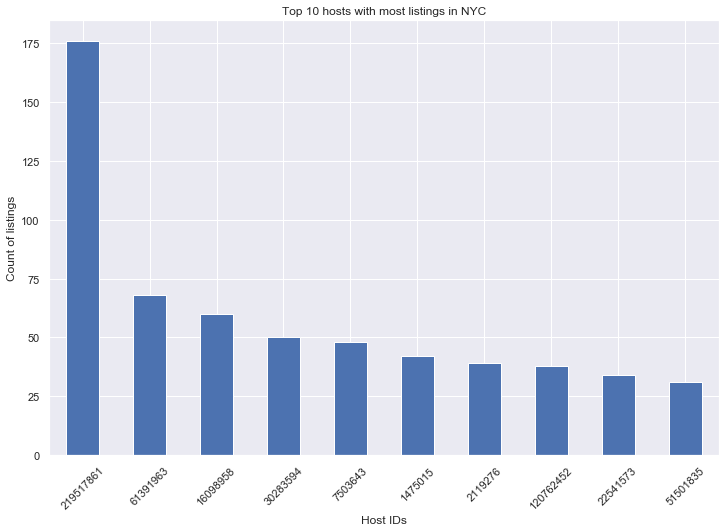

In [10]:
sns.set(rc={'figure.figsize':(12,8)})
plot_1=top_host.plot(kind='bar')
plot_1.set_title('Top 10 hosts with most listings in NYC')
plot_1.set_ylabel('Count of listings')
plot_1.set_xlabel('Host IDs')
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45);
# According to Airbnb's policy, licensed hotels and B&Bs are allowed to have multiple listings. The top host listed up
# to 170 listings on Airbnb. 

The top host listed up to 170 listings on Airbnb. These top hosts are hotel managers who rent out their condo hotel. 
	 
Now let us examine the type of accommodations in New York City. Airbnb's users do not like sharing room with others as we can see that it is only 2% of the listings. Private room – a legal type of rental in New York, captures 46% of the listings. Entire room captures 52% of the listings. This number is surprisingly high as New York state law regarding short-term
housing stated that it is almost always illegal to rent a full apartment when the host is not present 
for less than 30 days. 

In [11]:
# df[(df['host_id'] == 61391963)]

In [12]:
# top_neighbourhood_group=df.neighbourhood_cleansed.value_counts().head(10)
# top_neighbourhood_group

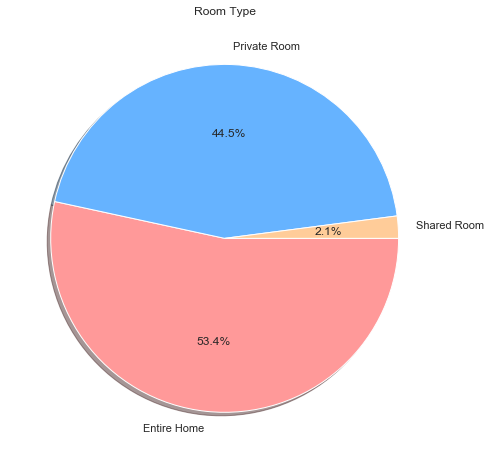

In [13]:
# Types of rooms
top_room_type=df.room_type.value_counts().head(3)


plt.pie(top_room_type, colors=['#ff9999','#66b3ff','#ffcc99'], 
        labels=['Entire Home', 'Private Room', 'Shared Room'],
        autopct='%1.1f%%',counterclock=False, shadow=True)
plt.title('Room Typxze')
plt.show()
# Entire room captures 52% of the listings. This number is surprisingly high. This means hosts live in another apartment 
# and have a year long listings, or hosts give up the apartment for certain days because the income from the apartment is high 
# enough to cover the cost. 
# New York state law regarding short-term housing stated that it is almost always illegal to rent a full apartment 
# when the host is not present or less than 30 days. 

In [14]:
# Airbnb's uers do not like sharing room with others as we can see that it is only 2% of the listings
# Private room - a legal type of rental in New York, captures 46% of the listings
# Entire room captures 52% of the listings. This number is surprisingly high. New York state law regarding short-term
# housing stated that it is almost always illegal to rent a full apartment when the host is not present 
# for less than 30 days. 

Furthermore, I will examine the distribution of listing across New York. Brooklyn and Manhattan, two already densely populated areas, have the greatest number of listings. 


In [15]:
'''What neighborhood offers the greatest number of listings?'''
# Create a Folium heat map for rooms distribution in New York City 
# The majority of the rooms is in Manhattan and Brooklyn
room_map = folium.Map(location=[40.7128, -74.0060], 
                      zoom_start = 12)
data_map = df[['latitude', 'longitude']]
data_map = [[row['latitude'], row['longitude']] for index, row in data_map.iterrows()]
HeatMap(data_map, radius=10).add_to(room_map)

room_map

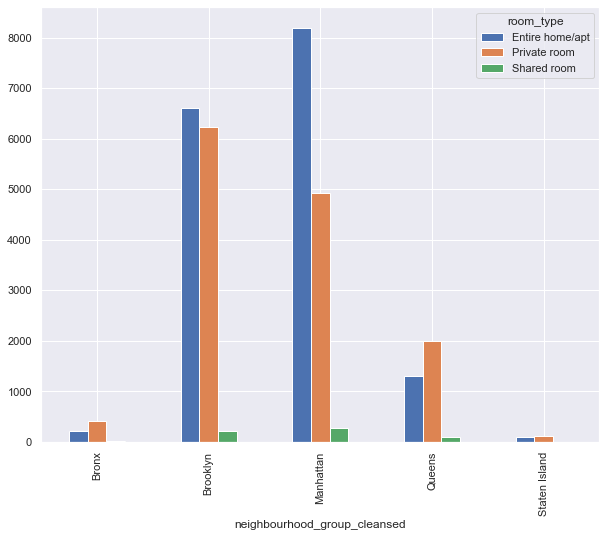

In [16]:
'''Listings by borough'''
# Is Airbnb taking up residential space in NYC? 
sns.set(rc={'figure.figsize':(10,8)})

fig, ax = plt.subplots()
df.groupby(['neighbourhood_group_cleansed','room_type'])['host_id'].count().unstack('room_type').plot.bar(ax=ax);

# Airbnb is putting more tourists in Manhattan & Brooklyn, which are already crowded areas. 

**2.	Price and Demand**

In this section, I will dive deeper into price and booking activity analysis for Airbnb listings. First, let us have a quick glance at how much it costs to rent a room in each borough. I apply the three-sigma rule to remove outliers as there were some properties costs USD0/night or USD10,000/night.  Manhattan has the highest median price per night of USD150/night, followed by Brooklyn with USD90/night. Queens and Staten Island appears to have the same median for price per night of USD70/night. Bronx has the lowest median price per night of approximately USD60/night. 

In [17]:
'''Price'''

def detect_outliers(data_1):
    mean = data_1.mean()
    sd = data_1.std()
    upper_bound = mean + 3 * sd
    lower_bound = mean - 3 * sd
    outliers = (data_1 > upper_bound) | (data_1 < lower_bound)
    return outliers

In [18]:
outliers_filtered = df.groupby('neighbourhood_group_cleansed', axis=0)['price'].apply(detect_outliers)

In [19]:
df_filtered = df[~outliers_filtered]

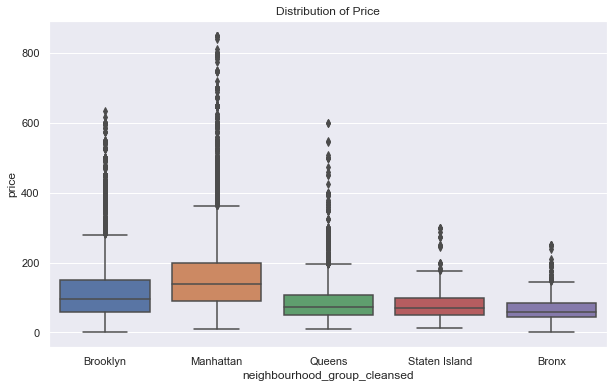

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x='neighbourhood_group_cleansed', 
            y='price', 
            data=df_filtered,
              ).set_title('Distribution of Price')
plt.show()

Now, let us take a closer look at the price distribution across the New York City to see which are the most expensive areas. Generally, it is more costly to stay near Downtown Manhattan area. The most expensive neighborhoods are Tribeca, Financial District and south of Staten Island. The price range for these areas are USD230 - USD275. It is no surprise that Downtown Manhattan offers the most expensive properties due to its proximity to major attractions such as Times Square, the Empire State Building, Rockefeller, and many great bars and restaurants. South of Staten Island, on the other hand, offer larger and rather more luxurious rooms which can accommodate more guests as compared to smaller rooms in pre-war buildings in Manhattan or Brooklyn. 


In [21]:
# Choropleth maps by median price
geo_group=df_filtered.groupby('zipcode')
geo_agg=geo_group.agg({'price':np.median,
                      })
geo_agg.rename(columns = {'price':'median_price'}, inplace = True)
geo_agg.reset_index(inplace=True)
geo_agg

,zipcode,median_price
0,10001,164.0
1,10002,130.0
2,10003,159.0
3,10004,137.0
4,10005,249.0
5,10006,180.0
6,10007,245.0
7,10009,135.0
8,10010,180.0
9,10011,185.0


In [22]:
# Load GeoJSON file
with open('nyu-2451-34509-geojson.json', 'r') as jsonFile:
    data=json.load(jsonFile)
ny_geo=data

In [23]:
def create_map(table, zips, mapped_feature, add_text = ''):
    # initiating a Folium map with NY's longitude and latitude
    m = folium.Map(location=[40.7128, -74.0060],
                   zoom_start=11)
    # creating a choropleth map
    m.choropleth(
        geo_data = ny_geo,
        fill_opacity = 0.9,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'properties.zcta',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        # handling the missing values in the map
        nan_fill_color='white',
        nan_fill_opacity=0.4,
        fill_color = 'YlGn',
        legend_name = ' '.join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across New York',
        reset=True
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')
    return m

In [24]:
create_map(geo_agg, 'zipcode', 'median_price')

/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [25]:
# Location with higher location score tends to have better connectivity and thus have the higher 
# median price per night

  The next step is to explore the review trend over the year to see how fast Airbnb has been growing. Overall, the review trend reflects the increasing demand for Airbnb over the past 10 years. The annual growth rate is roughly 40%. Additionally, there is a ‘wave’ in the graph, indicated that there is a seasonal demand for short-term rental. 


In [34]:
'''Reviews trend over the year'''
# Read the reviews file: 
reviews = pd.read_csv('reviews.csv')
reviews.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...


In [35]:
# Count the unique listing received reviews 
reviewsGroup = reviews.groupby('date').size()
reviewsGroup.index.name = 'date'
reviewsNum = reviewsGroup.reset_index(name='count')

In [36]:
from plotnine import *
from plotnine.data import *

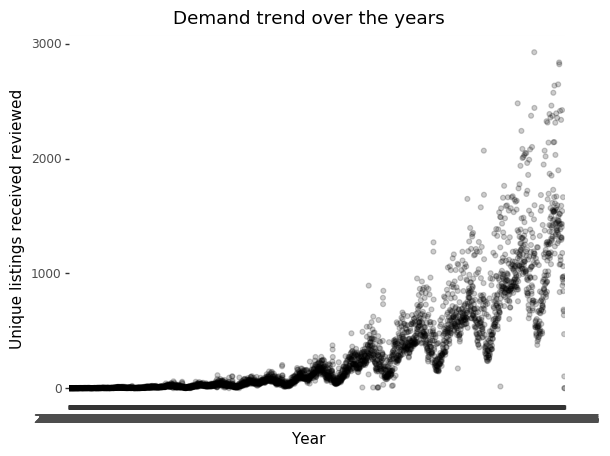

<ggplot: (-9223372029828586906)>

In [37]:
(
    ggplot(reviewsNum, aes(x='date', y='count'))
    + geom_point(alpha = 0.2)
    + geom_smooth(color = "#FF5A5F")
    + ggtitle('Demand trend over the years')
    + xlab('Year')
    + ylab('Unique listings received reviewed')
)

Similarly, let us learn more about the annual price trend. Due to limitation in the availability of data, I can only perform the price trend for 2019. It seems like the best time to travel to New York City is in January, when the price and demand are at their lowest points. There is a peak in August (when the holiday season started) and New Year Eve. 


In [38]:
# Reviews trend reflects the increasing demand for Airbnb in New York City over the years. 

In [39]:
reviewsNum['date'] = pd.to_datetime(reviewsNum['date'])
reviewsNum['year'] = reviewsNum['date'].dt.year
reviewsNum_2018 = reviewsNum.loc[reviewsNum.year==2018, :]
reviewsNum_2017 = reviewsNum.loc[reviewsNum.year==2017, :]
reviewsNum_2016 = reviewsNum.loc[reviewsNum.year==2016, :]

In [40]:
# reviewsNum_2018

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


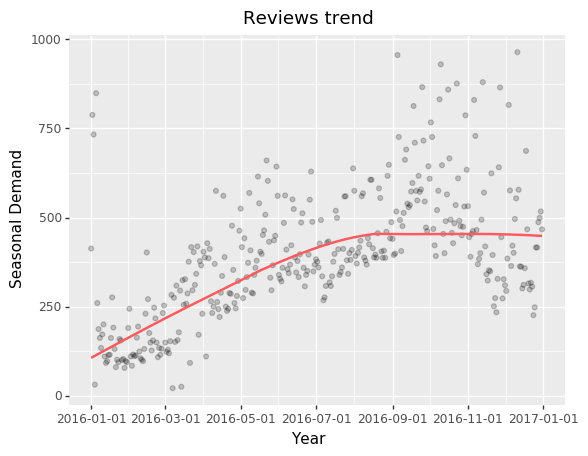

<ggplot: (7026190547)>

In [41]:
(
    ggplot(reviewsNum_2016, aes(x='date', y='count'))
    + geom_point(alpha = 0.2)
    + geom_smooth(color = "#FF5A5F")
    + ggtitle('Reviews trend')
    + xlab('Year')
    + ylab('Seasonal Demand')
)

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


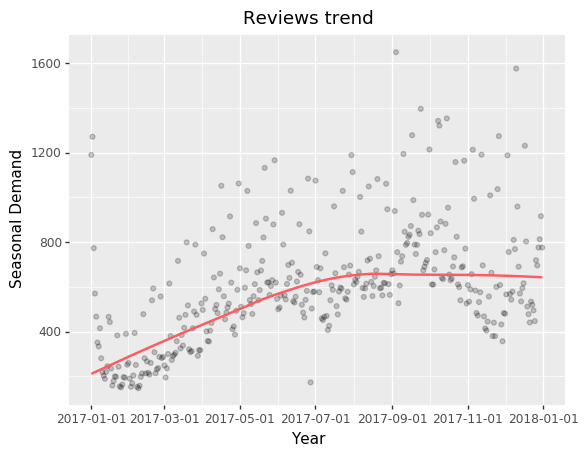

<ggplot: (-9223372029845818750)>

In [42]:
(
    ggplot(reviewsNum_2017, aes(x='date', y='count'))
    + geom_point(alpha = 0.2)
    + geom_smooth(color = "#FF5A5F")
    + ggtitle('Reviews trend')
    + xlab('Year')
    + ylab('Seasonal Demand')
)

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


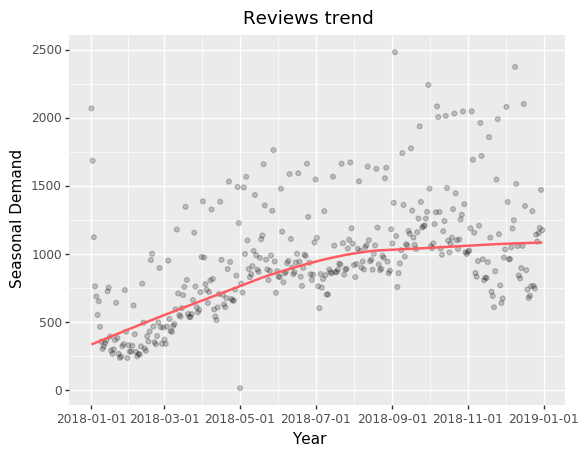

<ggplot: (7035079835)>

In [43]:
(
    ggplot(reviewsNum_2018, aes(x='date', y='count'))
    + geom_point(alpha = 0.2)
    + geom_smooth(color = "#FF5A5F")
    + ggtitle('Reviews trend')
    + xlab('Year')
    + ylab('Seasonal Demand')
)

In [44]:
# There is a peak in demand in August and perhaps another short peak in New Year period. 
# Demand increase is in line with the holiday period. 

In [45]:
calendar = pd.read_csv('calendar.csv')
calendar.head(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,38638,2019-08-06,f,$219.00,$219.00,4.0,200.0
1,16595,2019-08-06,t,$275.00,$275.00,1.0,1124.0
2,16595,2019-08-07,f,$225.00,$225.00,1.0,1124.0
3,16595,2019-08-08,t,$225.00,$225.00,1.0,1124.0
4,16595,2019-08-09,f,$225.00,$225.00,1.0,1124.0


In [46]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price             875
adjusted_price    875
minimum_nights    385
maximum_nights    385
dtype: int64

In [47]:
# Remove NaN value in price
calendar = calendar[calendar.price.notnull()].reset_index(drop=True)

In [48]:
# Remove dollar sign in price
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

In [49]:
# Median price per night over the year
calendarGroup = calendar.groupby('date')['price'].mean()
calendarGroup.index.name = 'date'
calendarMean = calendarGroup.reset_index(name='Average')

In [50]:
calendarMean['date'] = pd.to_datetime(calendarMean['date'])
calendarMean['year'] = calendarMean['date'].dt.year
calendarMean_2019 = calendarMean.loc[calendarMean.year==2019, :]

/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


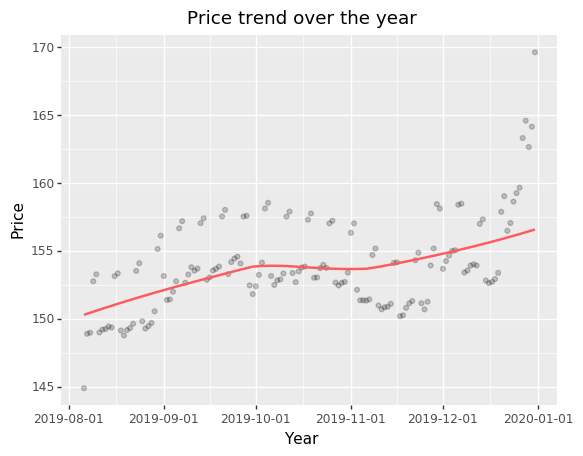

<ggplot: (7043526685)>

In [51]:
(
    ggplot(calendarMean_2019, aes(x='date', y='Average'))
    + geom_point(alpha=0.2)
    + geom_smooth(color = "#FF5A5F")
    + ggtitle('Price trend over the year')
    + xlab('Year')
    + ylab('Price')
)

In [52]:
# The rental price actually increases along the the year

In [26]:
# np.transpose(df[:2])

**3.	Reviews – the voice of customers**
Customers’ reviews provide tremendous insight into what customers like and dislike. In this section, I utilize the power of wordcloud to see what keywords are featured frequently. I take 1,000 random reviews to perform this analysis. Most frequently mentioned keywords such as “Times Square”, “Central Park”, “Columbus Circle”, “great location”, “subway” and “walking distance” indicate that customers strongly emphasize on the importance of location and connectivity to the top attractions. “Great hosts” and “great place” – nice and comfy accommodation – also play an important role in shaping customers’ experience. 


In [27]:
'''Generate a word cloud for the description summary'''
# We will generate a word cloud for top 100 listings with the most number of reviews

'Generate a word cloud for the description summary'

In [28]:
most_reviews = df.sort_values(by='number_of_reviews', ascending=False)

In [68]:
most_reviews.head(100)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
10031,9145202,https://www.airbnb.com/rooms/9145202,20190602163209,2019-06-03,Room near JFK Queen Bed,Complete address will be given when you have c...,We have worked very hard to make our place exc...,Complete address will be given when you have c...,none,Our neighborhood is very close to JFK. Were is...,...,t,f,flexible,f,f,2,0,2,0,14.52
1933,903972,https://www.airbnb.com/rooms/903972,20190602163209,2019-06-03,Great Bedroom in Manhattan,This is a Great Bedroom located in Manhattan!,I can not meet you and carry your luggage. I c...,This is a Great Bedroom located in Manhattan! ...,none,Food and transportation is close.,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,7.83
1920,891117,https://www.airbnb.com/rooms/891117,20190602163209,2019-06-03,Private Bedroom in Manhattan,This is a Private Bedroom in Manhattan!!,I can not meet you and carry your luggage. I c...,This is a Private Bedroom in Manhattan!! I can...,none,Food and transportation is close.,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,7.61
11242,10101135,https://www.airbnb.com/rooms/10101135,20190602163209,2019-06-03,Room Near JFK Twin Beds,Complete address will be given to guests after...,We have work very hard to make our place excep...,Complete address will be given to guests after...,none,Our neighborhood is very close to JFK. Were is...,...,t,f,flexible,f,f,2,0,2,0,13.25
362,105790,https://www.airbnb.com/rooms/105790,20190602163209,2019-06-03,Holiday special near Columbia Univ!,"It is a private, fully furnished room with a s...",Private bedroom in a spacious 2 bedroom apt. w...,"It is a private, fully furnished room with a s...",none,Definitely more neighborhoody feel here. It is...,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,6.02
1794,834190,https://www.airbnb.com/rooms/834190,20190602163209,2019-06-03,Manhattan Lux Loft.Like.Love.Lots.Look !,"Downtown, the best bit of Manhattan. One of, i...","Downtown Manhattan, .. just like you see it in...","Downtown, the best bit of Manhattan. One of, i...",none,Best neighborhood in Manhattan for independent...,...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,6.98
9120,8168619,https://www.airbnb.com/rooms/8168619,20190602163209,2019-06-03,Steps away from Laguardia airport,Large cozy room on the 2nd floor with two full...,Large size bedroom with two full size beds. It...,Large cozy room on the 2nd floor with two full...,none,The neighborhood does not have much to offer t...,...,t,f,strict_14_with_grace_period,f,f,5,0,5,0,11.64
16775,16276632,https://www.airbnb.com/rooms/16276632,20190602163209,2019-06-03,Cozy Room Family Home LGA Airport NO CLEANING FEE,Clean Cozy room in a family home LATE Check-In...,*Please note this room is for 1 GUEST ONLY: If...,Clean Cozy room in a family home LATE Check-In...,none,FOOD: Diner (94th st. / Astoria Blvd.) Super ...,...,t,f,strict_14_with_grace_period,f,f,5,0,4,1,16.24
4397,3474320,https://www.airbnb.com/rooms/3474320,20190602163209,2019-06-03,Private brownstone studio Brooklyn,Our private and cozy studio is located in char...,Studio apartment with kitchenette and bathroom...,Our private and cozy studio is located in char...,none,Park Slope is a historic area of Brooklyn with...,...,f,f,moderate,f,f,1,1,0,0,8.05
1213,546383,https://www.airbnb.com/rooms/546383,20190602163209,2019-06-03,My Little Guest Room in Flushing,"Close to public transport, one of two cozy lit...","This is a small space, big enough for two peop...","Close to public transport, one of two cozy lit...",none,Flushing is the biggest China town in all of N...,...,f,f,moderate,f,f,3,1,2,0,5.57


In [29]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm_notebook as tqdm

In [32]:
# comment_words

In [72]:
%%time
for val in tqdm(reviews['comments'].values[:1000]): 
    # typecaste each val to string
    val=str(val)
    # split the value
    tokens=val.split()
    # convert each token into lowercase
    for i in range(len(tokens)):
        tokens[i]=tokens[i].lower()
    for words in tokens: 
        comment_words=comment_words + ' '.join(tokens) + ' '


CPU times: user 13min 31s, sys: 12min 2s, total: 25min 34s
Wall time: 26min 6s


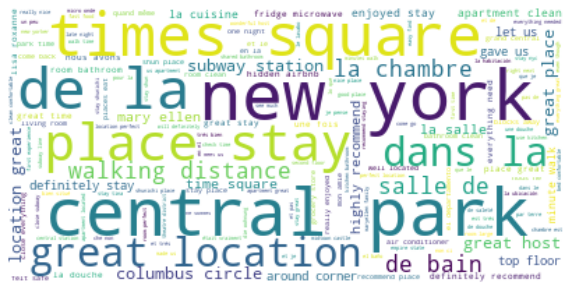

In [73]:
wordcloud= WordCloud(max_font_size=50, background_color="white", stopwords=stopwords).generate(comment_words)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()